<a href="https://colab.research.google.com/github/kimdesok/DeepPATH/blob/master/Transfer_Learning_of_Inception_by_COCO_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import argparse
import cv2

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

#Dataset preparation
>* Download MS COCO dataset
>* Common objects in context (COCO) is a large-scale object detection, segmentation, and captioning dataset.

reference: https://blog.cambridgespark.com/50-free-machine-learning-datasets-image-datasets-241852b03b49

In [26]:
#!wget http://images.cocodataset.org/zips/val2017.zip 
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#!unzip  /content/annotations_trainval2017.zip
#!unzip  /content/val2017.zip

# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 365s 0us/step


In [27]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [31]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> Two ladies in bikinis on surfboards at a beach <end>


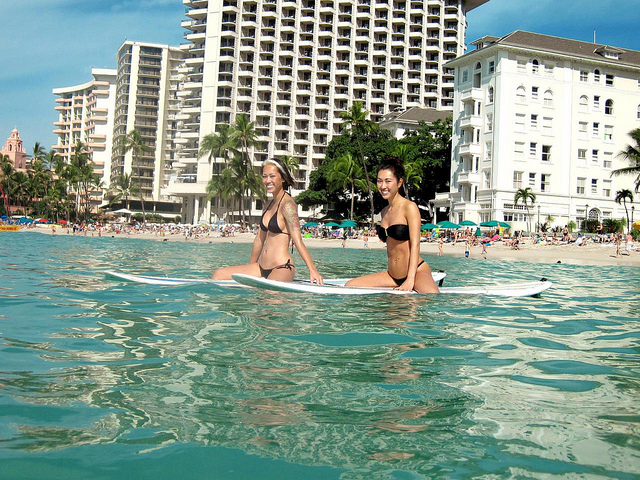

In [32]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [33]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

##Transfer learning of Inception v3 trained with Imagenet.

In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


Change the following line:

for img, path in image_dataset:

to:

for img, path in tqdm(image_dataset):

In [34]:
!pip install tqdm
from tqdm import tqdm


In [52]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [02:22<00:00,  2.64it/s]


In [53]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [54]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [55]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

##Split the data into training and testing

In [56]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [57]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6004, 6004)

## Create a tf.data dataset for training

In [58]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [59]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [60]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

##Model
Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
You squash that to a shape of (64, 2048).
This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
The RNN (here GRU) attends over the image to predict the next word.

https://www.tensorflow.org/tutorials/text/image_captioning#model

In [61]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [62]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [71]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [64]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [68]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [69]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [72]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

##Training
>* You extract the features stored in the respective .npy files and then pass those features through the encoder.
>* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
>* The decoder returns the predictions and the decoder hidden state.
>* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
>* Use teacher forcing to decide the next input to the decoder.
>* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
>* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [73]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [74]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9384
Epoch 1 Batch 100 Loss 1.1344
Epoch 1 Batch 200 Loss 0.9336
Epoch 1 Batch 300 Loss 0.9152
Epoch 1 Loss 1.026395
Time taken for 1 epoch 297.66 sec

Epoch 2 Batch 0 Loss 0.8846
Epoch 2 Batch 100 Loss 0.8093
Epoch 2 Batch 200 Loss 0.7619
Epoch 2 Batch 300 Loss 0.7411
Epoch 2 Loss 0.779557
Time taken for 1 epoch 170.70 sec

Epoch 3 Batch 0 Loss 0.7727


In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

    def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [36]:
!pip install setuptools
!pip install cython

In [41]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from skimage.transform import resize
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
dataDir='.'
dataType='train2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


loading annotations into memory...
Done (t=14.13s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture food sports electronic indoor outdoor animal vehicle appliance accessory kitchen person


In [47]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','hot','surfboard']);
print(catIds)
imgIds = coco.getImgIds(catIds=catIds );
print(imgIds)

[1, 42]
[327682, 122896, 434193, 253971, 253975, 278555, 49191, 139309, 499763, 319542, 254011, 385084, 376896, 122945, 401477, 16458, 327754, 327758, 32850, 278612, 254042, 573533, 204899, 106596, 516199, 295015, 508008, 32877, 254071, 163962, 409722, 49275, 90237, 467068, 139389, 147595, 270478, 114830, 458894, 458898, 565399, 508064, 245920, 164006, 475309, 557236, 16567, 377015, 450749, 49348, 565446, 327878, 114886, 286925, 540892, 319714, 303330, 172264, 557291, 24813, 229615, 254191, 221425, 418034, 516339, 131339, 516364, 352524, 262414, 270604, 287003, 368927, 360739, 65831, 123177, 221487, 475443, 33077, 213305, 254266, 98619, 287038, 557375, 311615, 573762, 221513, 139598, 319822, 115028, 434522, 409949, 155998, 205157, 524646, 491879, 246120, 393576, 565612, 65901, 287084, 65900, 303484, 377218, 156035, 74114, 123269, 180613, 532877, 262545, 229779, 180628, 221593, 377245, 541085, 270759, 508328, 41389, 524718, 565680, 565684, 401846, 49592, 74176, 25024, 295362, 524736, 45

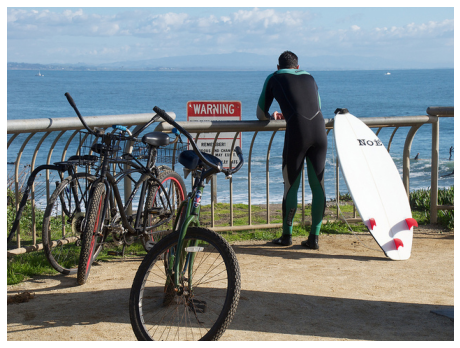

In [48]:
#imgIds = coco.getImgIds(imgIds = [8211])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

# load and display image
inputPath = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
I = io.imread(inputPath)
# use url to load image
#I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

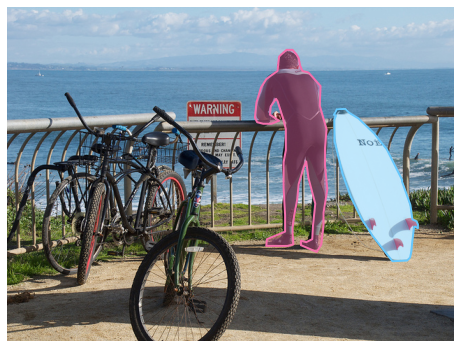

In [49]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

loading annotations into memory...
Done (t=6.15s)
creating index...
index created!


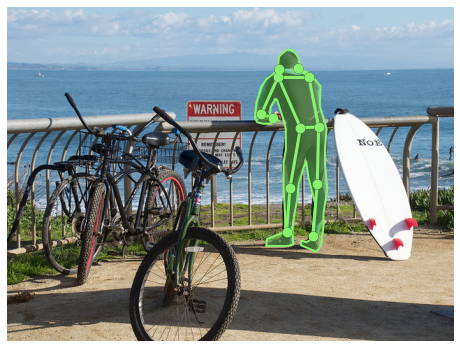

In [50]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
The man stands at the gate railing with a surfboard near parked bikes.
A surfer over looks the ocean from a cliff. 
A man leaning on a rail with a surfboard next to it.
a nab is standing next to his surfboard
The bikes are locked up in the sack by the ocean.


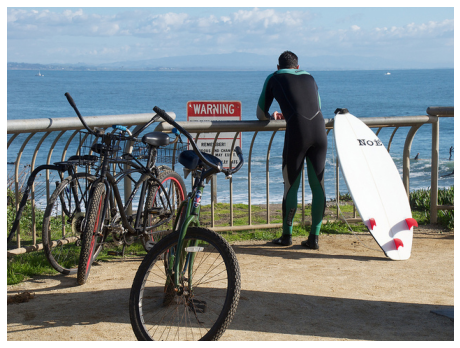

In [51]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

In [ ]:
# define a dictionary that maps model names to their classes
# inside Keras
MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}
# 224×224 input images for VGG!6, VGG!9 and RestNet
# 299x299 input images for Inception V3 and Xception

# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
#Select a model from the above MODELS dict.
inputModel = 'inception'

# path to the image folder
#inputPath = '/content/val2017'
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image pre-processing function
if inputModel in ("inception", "xception"):
	inputShape = (299, 299)
	preprocess = preprocess_input
print(inputShape)

# load our the network weights from disk (NOTE: if this is the
# first time you are running this script for a given network, the
# weights will need to be downloaded first -- depending on which
# network you are using, the weights can be 90-575MB, so be
# patient; the weights will be cached and subsequent runs of this
# script will be *much* faster)
print("[INFO] loading {}...".format(inputModel))
Network = MODELS[inputModel]
model = Network(weights="imagenet")

(224, 224)
[INFO] loading resnet...
102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
print(inputPath)

./val2017/000000184611.jpg


[INFO] loading and pre-processing images from ./val2017/000000184611.jpg...
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


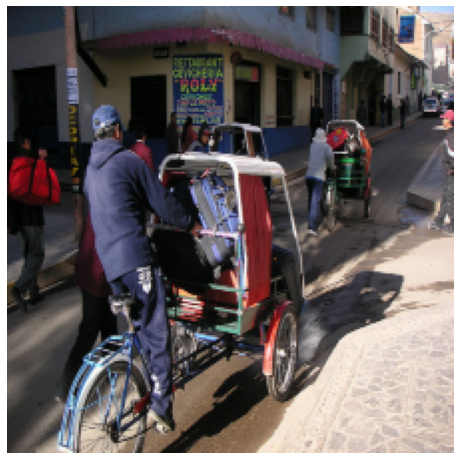

In [ ]:
# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
#inputPath = r'/content/val2017/000000000139.jpg'
# img['coco_url'] #
print("[INFO] loading and pre-processing images from {}...".format(inputPath))
image = io.imread(inputPath) #load_img(inputPath, target_size=inputShape)

image = resize(image, inputShape)
plt.axis('off')
plt.imshow(image)

image = img_to_array(image)
print(image.shape)
# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through the network
image = np.expand_dims(image, axis=0)
print(image.shape)
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image = preprocess(image)
print(image.shape)



In [ ]:
# classify the image
print("[INFO] classifying {} with '{}'...".format(inputPath, inputModel))
preds = model.predict(image)
P = imagenet_utils.decode_predictions(preds, top=5)
# loop over the predictions and display the rank-5 predictions +
# probabilities to our terminal
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
	print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

[INFO] classifying ./val2017/000000184611.jpg with 'resnet'...
49152/35363 [=========================================] - 0s 0us/step
1. matchstick: 5.46%
2. digital_clock: 5.45%
3. web_site: 4.48%
4. nematode: 3.76%
5. television: 3.14%


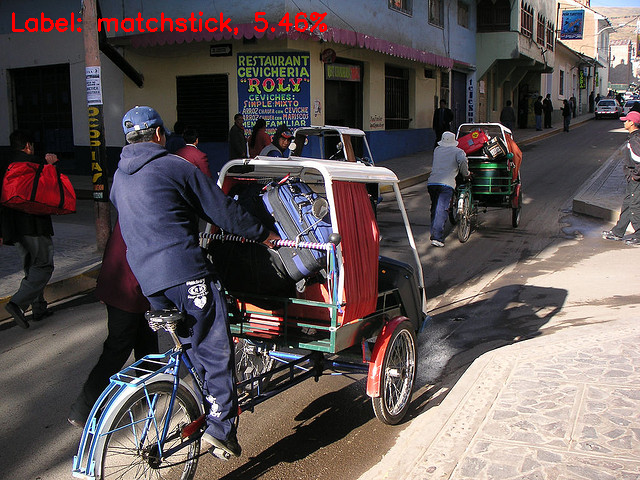

Guy pedals a bike through a small village.
A city street with small carts bing peddled by a men on bikes 
A man drives his bike taxi with luggage in the back.
People riding and pushing tricycle carriages down the street.
People use rickshaws to transport luggage down the street.


In [ ]:
# load the image via OpenCV, draw the top prediction on the image,
# and display the image to our screen

from google.colab.patches import cv2_imshow

orig = cv2.imread(inputPath)
(imagenetID, label, prob) = P[0][0]
cv2.putText(orig, "Label: {}, {:.2f}%".format(label, prob * 100),
	(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
cv2_imshow(orig)
cv2.waitKey(0)

coco_caps.showAnns(anns)